# Bioscrape Interacting Lineages (Beta)

Warning: Bioscrape interacting lineages is unstable at this point.

# Example 1 Interacting Cells are many SSA trajectories simulated independently and synchronized by remixing global species every $\Delta T$ time

('simulating interacting lineage from ', 2.0, ' to ', 4.0)
('simulating interacting lineage from ', 4.0, ' to ', 6.0)
('simulating interacting lineage from ', 6.0, ' to ', 8.0)
('simulating interacting lineage from ', 8.0, ' to ', 10.0)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 1.0, 'Cells Exchanging X with Each Other and the Enviornment')

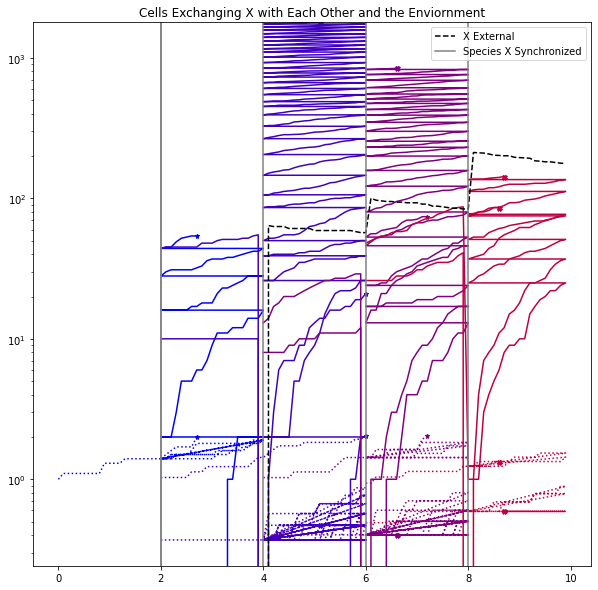

In [12]:
from bioscrape.lineage import py_SimulateInteractingCellLineage, LineageModel, LineageVolumeSplitter
from bioscrape.types import Model
import numpy as np
import pylab as plt
from time import process_time

global_sync_period = 2
global_volume = 150
average_dist_threshold = 1
initial_cell_counts = [1]

#Python Code to create the model
ktx = .6
ktl = 2.5
kd = .04
rxns = [
    (["G"], ["G","T"], "massaction", {"k":ktx}),
    (["T"], ["T","X"], "massaction", {"k":ktl}),
    (["T"], [], "massaction", {"k":kd}),
]

x0 = {"G":1}
M = LineageModel(reactions = rxns, initial_condition_dict = x0)

vsplit_options = {
    "default":"binomial",
    "G":"duplicate",
}
vsplit = LineageVolumeSplitter(M, options = vsplit_options)

delta = 1
M.create_division_rule("deltaV", {"threshold":delta}, vsplit)
g = .1
kgrow = 1.2
#M.create_volume_event("linear volume", {"growth_rate":g}, "hillnegative", {"k":kgrow, "s1":"S", "n":2, "K":Kgrow})
M.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":kgrow, "species":""})
kdeath = .08
Kdeath = 25
M.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":"X", "n":2, "K":Kdeath})
M.py_initialize()


kdeg = .1
global_rxns = [(["X"], [""], "massaction", {"k":kdeg})]
global_crn = Model(species = ["X"], reactions = global_rxns)

tmax = 10
dt = .1
timepoints = np.arange(0, tmax, dt)
lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, 
                                                                            global_volume = global_volume, 
                                                                            model_list = [M],
                                                                            initial_cell_states = initial_cell_counts,
                                                                            global_species = ["X"],
                                                                            global_volume_model = global_crn,
                                                                            average_dist_threshold = average_dist_threshold,
                                                                            safe = False)

lineage_interacting = lineage_list[0]
sch_tree = lineage_interacting.get_schnitzes_by_generation()
color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]
ms = 5
ymin = 0
ymax = 0
plt.figure(figsize = (10, 10))
for generation in range(len(sch_tree)):
    L = sch_tree[generation]
    for sch_ind in range(len(L)):
        sch = L[sch_ind]
    
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df["volume"], ":", color = color_list[generation])
        
        plt.plot(df["time"], df["X"], color = color_list[generation])
        ymax = max(ymax, np.max(df["X"]))
        
        dead = sch.py_get_daughters()[0] is None and df["time"][len(df["time"])-1] < timepoints[-1]
        divided = sch.py_get_daughters()[0] is not None and df["time"][len(df["time"])-1] < timepoints[-1]
        
        if dead:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "X", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "X", ms = ms, color = color_list[generation])
        if divided:
            plt.plot(df["time"][len(df["time"])-1], df["volume"][len(df["volume"])-1], "*", ms = ms, color = color_list[generation])
            plt.plot(df["time"][len(df["time"])-1], df["X"][len(df["X"])-1], "*", ms = ms, color = color_list[generation])

df_global = global_results.py_get_dataframe(Model = global_crn)
plt.plot(df_global["time"], df_global["X"], "--", label = "X External", color = "black")


for i in range(global_sync_period, tmax, global_sync_period):
    if i == global_sync_period:
        plt.plot([i, i], [ymin, ymax], color = "grey", label = "Species X Synchronized")
    plt.plot([i, i], [ymin, ymax], color = "grey")

plt.yscale('log')
plt.ylim(ymin, ymax)
plt.legend()
plt.title("Cells Exchanging X with Each Other and the Enviornment")

## Example 2: 2 Cell Types Interacting in their Environment

### Cell Type One Consumes Food (F) from the Environment and Produces Waste (W). It's growth rate is based on the amount of F. It dies if exposed to too much W.

### Cell Type 2 Consumes Wast (W) from the Environment. It's growth rate is based on the amount of W.

In [13]:
#A global mode with no reactions is just a container
global_x0 = {"W":0, "F":100}

#Use the Same Parameters for both cell types
ke = .05
g = .025

kgrow = 100
Kgrow = 5

kdeath = 1.0
Kdeath = 100

#cell type 1 consumes F (Food) to produce W (Waste) and E (internal machinery aka enzymes)
species = ["F","W", "E"]
rxn1 = [["F","E"], ["E","E","W"], "massaction", {"k":ke}]
Mcell1 = LineageModel(species = species, reactions = [rxn1], initial_condition_dict = {"E":5})

vsplit = LineageVolumeSplitter(Mcell1)
Mcell1.create_division_rule("deltaV", {"threshold":1.0}, vsplit)
#E (enzymes) allow the cell to divide
Mcell1.create_volume_event("linear volume", {"growth_rate":g}, "hillpositive", {"k":kgrow, "s1":"E", "n":2, "K":Kgrow})
#Too much waste and the cell dies
Mcell1.create_death_event("death", {}, "hillpositive", {"k":kdeath, "s1":"W", "n":4, "K":Kdeath})
#too few enzymes and cell 1 two might die
Mcell1.create_death_event("death", {}, "hillnegative", {"k":.05*kdeath, "s1":"E", "n":4, "K":2})

#Add a food source
kf = .1
rxng = [[], ["F"], "massaction", {"k":kf}]
x0g = {"F":0, "W":0}
Mglobal = Model(species = ["F"], reactions = [rxng], initial_condition_dict = x0g)


#Cell type 2 consumes W to produce E
species = ["W", "E"]
rxn2 = [["W","E"], ["E","E"], "massaction", {"k":ke}]
Mcell2 = LineageModel(species = species, reactions = [rxn1], initial_condition_dict = {"E":5})


vsplit = LineageVolumeSplitter(Mcell2)
Mcell2.create_division_rule("deltaV", {"threshold":1.0}, vsplit)
Mcell2.create_volume_event("linear volume", {"growth_rate":g}, "hillpositive", {"k":kgrow, "s1":"E", "n":2, "K":Kgrow})
#too few enzymes and cell 2 two might die
Mcell2.create_death_event("death", {}, "hillnegative", {"k":.05*kdeath, "s1":"E", "n":4, "K":2})

In [14]:
maxtime = 80
dt = 0.01
global_sync_period = 1.0
global_volume = 1000 #Is the volume that all the cells are growing. If its 0, there is no external volume.
average_dist_threshold = 2.

timepoints = np.arange(0, maxtime+dt, dt)

global_species = ["F", "W"]
model_list = [Mcell1, Mcell2]
initial_cell_counts = [5, 5]

print("Simulating")
ts = process_time()
lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, global_volume = global_volume,
                                                 model_list = model_list, global_volume_model = Mglobal,
                                                 initial_cell_states = initial_cell_counts, 
                                                 global_species = global_species, 
                                                 average_dist_threshold = average_dist_threshold)
df_global = global_results.py_get_dataframe(Model = Mglobal)

for lineage in lineage_list:
    sch_tree = lineage.get_schnitzes_by_generation()
    print("Total Cells Simulated = ", sum([len(L) for L in sch_tree]),"\nCells of each generation:", [len(L) for L in sch_tree], )

Simulating
('simulating interacting lineage from ', 1.0, ' to ', 2.0)
('simulating interacting lineage from ', 2.0, ' to ', 3.0)
('simulating interacting lineage from ', 3.0, ' to ', 4.0)
('simulating interacting lineage from ', 4.0, ' to ', 5.0)
('simulating interacting lineage from ', 5.0, ' to ', 6.0)
('simulating interacting lineage from ', 6.0, ' to ', 7.0)
('simulating interacting lineage from ', 7.0, ' to ', 8.0)
('simulating interacting lineage from ', 8.0, ' to ', 9.0)
('simulating interacting lineage from ', 9.0, ' to ', 10.0)
('simulating interacting lineage from ', 10.0, ' to ', 11.0)
('simulating interacting lineage from ', 11.0, ' to ', 12.0)
('simulating interacting lineage from ', 12.0, ' to ', 13.0)
('simulating interacting lineage from ', 13.0, ' to ', 14.0)
('simulating interacting lineage from ', 14.0, ' to ', 15.0)
('simulating interacting lineage from ', 15.0, ' to ', 16.0)
('simulating interacting lineage from ', 16.0, ' to ', 17.0)
('simulating interacting linea

Plotting


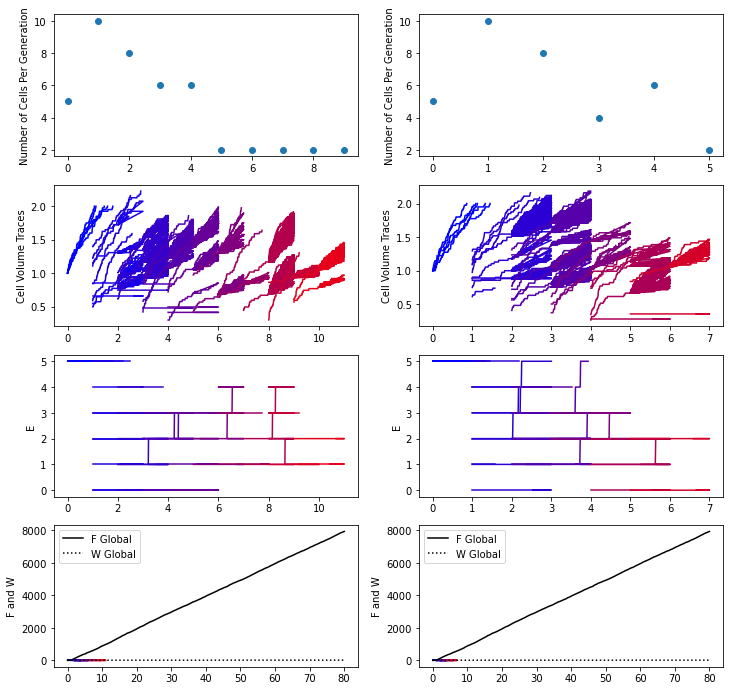

In [15]:
# A little plotting
import pylab as plt

print("Plotting")
plt.figure(figsize = (12, 12))

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = plt.subplot(421), plt.subplot(422), plt.subplot(423), plt.subplot(424), plt.subplot(425), plt.subplot(426), plt.subplot(427), plt.subplot(428)
axes = [ax1, ax3, ax5, ax7, ax2, ax4, ax6, ax8]

for lind in range(len(lineage_list)):
    lineage = lineage_list[lind]
    M = model_list[lind]
    sch_tree = lineage.get_schnitzes_by_generation()
    color_list = [(i/len(sch_tree), 0, 1.-i/len(sch_tree)) for i in range(len(sch_tree))]


    #Plot Generation Counts
    plt.sca(axes[4*lind])
    plt.plot(range(len(sch_tree)), [len(L) for L in sch_tree], "o")
    plt.ylabel("Number of Cells Per Generation")
    

    #Plot Volume Traces
    plt.sca(axes[4*lind+1])
    for generation in range(len(sch_tree)):
        L = sch_tree[generation]
        for sch in L:
            df = sch.py_get_dataframe(Model = M)
            plt.plot(df["time"], df["volume"], color = color_list[generation])
    plt.ylabel("Cell Volume Traces")

    #Plot E
    plt.sca(axes[4*lind+2])
    for generation in range(len(sch_tree)):
        L = sch_tree[generation]
        for sch in L:
            df = sch.py_get_dataframe(Model = M)
            plt.plot(df["time"], df["E"], color = color_list[generation])
    plt.ylabel("E")
    
    #Plot F, W
    plt.sca(axes[4*lind+3])
    for generation in range(len(sch_tree)):
        L = sch_tree[generation]
        for sch in L:
            df = sch.py_get_dataframe(Model = M)
            plt.plot(df["time"], df["F"], color = color_list[generation])
            plt.plot(df["time"], df["W"], ":", color = color_list[generation])
            
    plt.plot(df_global["time"], df_global["F"], color = "black", label = "F Global")
    plt.plot(df_global["time"], df_global["W"], ":", color = "black", label = "W Global")
    plt.legend()
    plt.ylabel("F and W")



# Propogate Cells is simpler than a faster lineage simulation and returns snapshots at periodic timepoints

In [16]:
from bioscrape.lineage import py_PropagateInteractingCells
print("Simulating")
ts = process_time()
#Instead of simulating a whole cell Lineage, use propogate cells to get snapshots over time
#lineage_list, global_results, simulator = py_SimulateInteractingCellLineage(timepoints, global_sync_period, global_volume = global_volume,
#                                                 model_list = model_list, global_volume_model = Mglobal,
#                                                 initial_cell_states = initial_cell_counts, 
#                                                 global_species = global_species, 
#                                                 average_dist_threshold = average_dist_threshold)

Nsamples = 11
sample_list, sample_times, global_results, simulator = py_PropagateInteractingCells(timepoints, global_sync_period, 
                                                 sample_times = Nsamples, global_volume = global_volume,
                                                 model_list = model_list, global_volume_model = Mglobal,
                                                 initial_cell_states = initial_cell_counts, 
                                                 global_species = global_species, 
                                                 average_dist_threshold = average_dist_threshold)
te = process_time()
print("Simulation Complete in", te-ts, "s")

print("N cell 1:", [len(L[0]) for L in sample_list])
print("N cell 2:", [len(L[1]) for L in sample_list])

Simulating
Simulation Complete in 0.0625 s
N cell 1: [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
N cell 2: [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[[7940.   12.]
 [ 689.    0.]
 [1558.    0.]
 [2359.    0.]
 [3165.    0.]
 [3986.    0.]
 [4800.    0.]
 [5557.    0.]
 [6369.    0.]
 [7223.    0.]
 [7978.    0.]]
sample_times [ 0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80.]


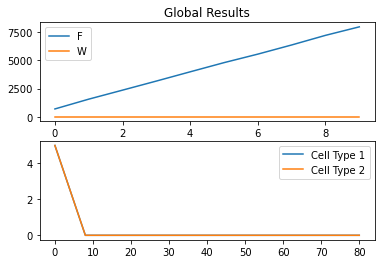

In [17]:
print(global_results.py_get_result())
print("sample_times", sample_times)
plt.figure()
plt.subplot(211)
plt.title("Global Results")
plt.plot(global_results.py_get_result()[1:, 0], label = "F")
plt.plot(global_results.py_get_result()[1:, 1], label = "W")
plt.legend()

plt.subplot(212)
plt.plot(sample_times, [len(L[0]) for L in sample_list], label = "Cell Type 1")
plt.plot(sample_times, [len(L[1]) for L in sample_list], label = "Cell Type 2")
plt.legend()